In [9]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from utils import check_nan, check_unique
from matplotlib import gridspec
from matplotlib import rcParams
from collections import Counter

#Paramètres graphiques 
rcParams['figure.figsize'] = 15,8 #Taille de la figure affichée
sns.set_style("darkgrid")#style de l'arrière plan de seaborn 
sns.set_palette("pastel")#Couleurs utilisées dans les graphiques 
plt.rcParams["figure.dpi"] = 200 #dpi = dot per inch , résolution des graphiques 
pd.set_option('display.max_columns', 500) #Nombre de colonne maximum du dataframe à afficher

# import warnings
# warnings.simplefilter(action='ignore')

# Lecture et mise en forme des données

# Mise en forme des données :

In [2]:
data=pd.read_csv("./data/delays.csv")
data.columns= ["save_datetime","id_train_complet","transporteur","date_depart","depart_destination","arrivee_prevue","retard","nom_station"]

data["save_datetime"]=pd.to_datetime(data["save_datetime"])
data["date_depart"]=pd.to_datetime(data["date_depart"])


#Drop des lignes avec une horaire prévue inexploitatble :
df=data[data["arrivee_prevue"]!='Nie dotyczy']


#Conversion du retard en entier : 
df["retard"]=df["retard"].str.split(" ").str[0].astype('int')

#df[["depart","destination"]]= df["depart_destination"].str.split(" - ", expand=True)

new_id=df["id_train_complet"].str.extract(r"(\d+)(\/\d+)?\s*(\(\d+\)|)?(\s*)(.*|[a-zA-Z\u00C0-\u017F]*)").add_prefix('index_part')
df=df.merge(new_id, left_index=True, right_index=True).drop(['index_part3'], axis=1).rename(columns={"index_part4": "index_part3","index_part0":"id_train"})

df=df.fillna("")

#On ne garde que les lignes qui nous intéressent 
df =df.sort_values("save_datetime").drop_duplicates(["id_train_complet","transporteur","date_depart","depart_destination","arrivee_prevue","nom_station"],keep="last").sort_values("save_datetime")

df["arrivee_prevue"]=pd.to_datetime(df["arrivee_prevue"], format='%H:%M').dt.time

print("Shape du dataset d'origine :", data.shape)
print("Shape du dataset contenant uniquement les lignes qui nous intéressent : ",df.shape)
df.head()

C:\Users\bruno\AppData\Local\Temp\ipykernel_4192\1015363773.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["retard"]=df["retard"].str.split(" ").str[0].astype('int')


Shape du dataset d'origine : (3718170, 8)
Shape du dataset contenant uniquement les lignes qui nous intéressent :  (264141, 12)


,save_datetime,id_train_complet,transporteur,date_depart,depart_destination,arrivee_prevue,retard,nom_station,id_train,index_part1,index_part2,index_part3
175,2022-05-16,95697,PKP SKM w Trójmieście Sp. z o.o.,2022-05-15,Gdańsk Zaspa - Wejherowo,23:38:00,24,Reda Pieleszewo,95697,,,
68,2022-05-16,91888/9,Koleje Mazowieckie,2022-05-16,Siedlce - Warszawa Zachodnia,00:01:00,2,Warszawa Stadion,91888,/9,,
111,2022-05-16,59486,PKP SKM w Trójmieście Sp. z o.o.,2022-05-15,Gdynia Cisowa - Gdańsk Główny,23:54:00,9,Gdańsk Żabianka-AWFiS,59486,,,
119,2022-05-16,95699,PKP SKM w Trójmieście Sp. z o.o.,2022-05-16,Gdańsk Śródmieście - Wejherowo,00:04:00,0,Gdynia Wzgórze Św.Maksymiliana,95699,,,
116,2022-05-16,95699,PKP SKM w Trójmieście Sp. z o.o.,2022-05-16,Gdańsk Śródmieście - Wejherowo,00:01:00,0,Gdynia Redłowo,95699,,,


In [3]:
check_nan(df)
print("\n")
check_unique(df)

Valeurs nan dans save_datetime : 0
Valeurs nan dans id_train_complet : 0
Valeurs nan dans transporteur : 0
Valeurs nan dans date_depart : 0
Valeurs nan dans depart_destination : 0
Valeurs nan dans arrivee_prevue : 0
Valeurs nan dans retard : 0
Valeurs nan dans nom_station : 0
Valeurs nan dans id_train : 0
Valeurs nan dans index_part1 : 0
Valeurs nan dans index_part2 : 0
Valeurs nan dans index_part3 : 0


Valeurs uniques dans save_datetime : 4024
Valeurs uniques dans id_train_complet : 7947
Valeurs uniques dans transporteur : 10
Valeurs uniques dans date_depart : 16
Valeurs uniques dans depart_destination : 995
Valeurs uniques dans arrivee_prevue : 1390
Valeurs uniques dans retard : 263
Valeurs uniques dans nom_station : 95
Valeurs uniques dans id_train : 3447
Valeurs uniques dans index_part1 : 11
Valeurs uniques dans index_part2 : 75
Valeurs uniques dans index_part3 : 335


#### On a fortement réduit la taille du dataset 

# Observations sur les id_train  : 

# Feature preprocessing : 

## Extraction de départ - destination : 

In [4]:
df[['depart','destination']] = df["depart_destination"].str.split(" - ",expand=True,)
df.head()

,save_datetime,id_train_complet,transporteur,date_depart,depart_destination,arrivee_prevue,retard,nom_station,id_train,index_part1,index_part2,index_part3,depart,destination
175,2022-05-16,95697,PKP SKM w Trójmieście Sp. z o.o.,2022-05-15,Gdańsk Zaspa - Wejherowo,23:38:00,24,Reda Pieleszewo,95697,,,,Gdańsk Zaspa,Wejherowo
68,2022-05-16,91888/9,Koleje Mazowieckie,2022-05-16,Siedlce - Warszawa Zachodnia,00:01:00,2,Warszawa Stadion,91888,/9,,,Siedlce,Warszawa Zachodnia
111,2022-05-16,59486,PKP SKM w Trójmieście Sp. z o.o.,2022-05-15,Gdynia Cisowa - Gdańsk Główny,23:54:00,9,Gdańsk Żabianka-AWFiS,59486,,,,Gdynia Cisowa,Gdańsk Główny
119,2022-05-16,95699,PKP SKM w Trójmieście Sp. z o.o.,2022-05-16,Gdańsk Śródmieście - Wejherowo,00:04:00,0,Gdynia Wzgórze Św.Maksymiliana,95699,,,,Gdańsk Śródmieście,Wejherowo
116,2022-05-16,95699,PKP SKM w Trójmieście Sp. z o.o.,2022-05-16,Gdańsk Śródmieście - Wejherowo,00:01:00,0,Gdynia Redłowo,95699,,,,Gdańsk Śródmieście,Wejherowo


In [5]:
df["datetime_save"]=df["save_datetime"].dt.strftime('%Y-%m-%d %H:%M:%S')

In [6]:
df.head()

,save_datetime,id_train_complet,transporteur,date_depart,depart_destination,arrivee_prevue,retard,nom_station,id_train,index_part1,index_part2,index_part3,depart,destination,datetime_save
175,2022-05-16,95697,PKP SKM w Trójmieście Sp. z o.o.,2022-05-15,Gdańsk Zaspa - Wejherowo,23:38:00,24,Reda Pieleszewo,95697,,,,Gdańsk Zaspa,Wejherowo,2022-05-16 00:00:00
68,2022-05-16,91888/9,Koleje Mazowieckie,2022-05-16,Siedlce - Warszawa Zachodnia,00:01:00,2,Warszawa Stadion,91888,/9,,,Siedlce,Warszawa Zachodnia,2022-05-16 00:00:00
111,2022-05-16,59486,PKP SKM w Trójmieście Sp. z o.o.,2022-05-15,Gdynia Cisowa - Gdańsk Główny,23:54:00,9,Gdańsk Żabianka-AWFiS,59486,,,,Gdynia Cisowa,Gdańsk Główny,2022-05-16 00:00:00
119,2022-05-16,95699,PKP SKM w Trójmieście Sp. z o.o.,2022-05-16,Gdańsk Śródmieście - Wejherowo,00:04:00,0,Gdynia Wzgórze Św.Maksymiliana,95699,,,,Gdańsk Śródmieście,Wejherowo,2022-05-16 00:00:00
116,2022-05-16,95699,PKP SKM w Trójmieście Sp. z o.o.,2022-05-16,Gdańsk Śródmieście - Wejherowo,00:01:00,0,Gdynia Redłowo,95699,,,,Gdańsk Śródmieście,Wejherowo,2022-05-16 00:00:00


In [7]:
len(df["id_train_complet"].unique())

7947

In [10]:
travel_dict={}
for i in df["id_train_complet"].unique():
    a=df[df["id_train_complet"]==i].sort_values(["date_depart",'id_train_complet',"arrivee_prevue"])["nom_station"].tolist()
    if Counter(a).most_common()[0][1]-Counter(a).most_common()[-1][1]<2:
        start_station=Counter(a).most_common()[-1][0]
        s=-1
    else:
        start_station=Counter(a).most_common()[-2][0]
        s=-2
    
    if Counter(a).most_common()[s][1]>1:
        start=a.index(start_station)
        stop=[j for j, n in enumerate(a) if n == start_station][1]
        travel_dict[i]=a[start:stop]
    else:
        travel_dict[i]=a
travel_dict

{'95697  ': ['Reda',
  'Reda Pieleszewo',
  'Wejherowo Śmiechowo',
  'Wejherowo-Nanice',
  'Wejherowo',
  'Gdańsk Główny',
  'Gdańsk Stocznia',
  'Gdańsk Politechnika',
  'Gdańsk Wrzeszcz',
  'Gdańsk Zaspa',
  'Gdańsk Przymorze-Uniwersytet',
  'Gdańsk Żabianka-AWFiS',
  'Sopot Wyścigi',
  'Sopot',
  'Sopot Kamienny Potok',
  'Gdynia Redłowo',
  'Gdynia Wzgórze Św.Maksymiliana',
  'Gdynia Główna',
  'Gdynia Stocznia-Uniwersytet Morski',
  'Gdynia Leszczynki',
  'Gdynia Chylonia',
  'Gdynia Cisowa',
  'Rumia Janowo',
  'Rumia'],
 '91888/9  ': ['Warszawa Wschodnia',
  'Warszawa Stadion',
  'Warszawa Powiśle',
  'Warszawa Śródmieście',
  'Warszawa Ochota',
  'Warszawa Zachodnia',
  'Warszawa Rembertów',
  'Warszawa Stadion',
  'Warszawa Powiśle',
  'Warszawa Śródmieście',
  'Warszawa Ochota',
  'Warszawa Rembertów'],
 '59486  ': ['Sopot',
  'Sopot Wyścigi',
  'Gdańsk Żabianka-AWFiS',
  'Gdańsk Przymorze-Uniwersytet',
  'Gdańsk Zaspa',
  'Gdańsk Wrzeszcz',
  'Gdańsk Politechnika',
  'Gdańsk

In [11]:
df["travel"]=df.apply(lambda x: travel_dict[x["id_train_complet"]], axis=1)
df["num_station"]=df.apply(lambda x: travel_dict[x["id_train_complet"]].index(x["nom_station"])
                            if x["nom_station"] in x["travel"] else -1 , axis=1)

In [12]:
df[df["id_train_complet"]=="95697  "].sort_values(["date_depart",'id_train']).iloc[:30]

,save_datetime,id_train_complet,transporteur,date_depart,depart_destination,arrivee_prevue,retard,nom_station,id_train,index_part1,index_part2,index_part3,depart,destination,datetime_save,travel,num_station
175,2022-05-16 00:00:00,95697,PKP SKM w Trójmieście Sp. z o.o.,2022-05-15,Gdańsk Zaspa - Wejherowo,23:38:00,24,Reda Pieleszewo,95697,,,,Gdańsk Zaspa,Wejherowo,2022-05-16 00:00:00,"[Reda, Reda Pieleszewo, Wejherowo Śmiechowo, W...",1
373,2022-05-16 00:05:00,95697,PKP SKM w Trójmieście Sp. z o.o.,2022-05-15,Gdańsk Zaspa - Wejherowo,23:47:00,23,Wejherowo,95697,,,,Gdańsk Zaspa,Wejherowo,2022-05-16 00:05:00,"[Reda, Reda Pieleszewo, Wejherowo Śmiechowo, W...",4
411,2022-05-16 00:05:00,95697,PKP SKM w Trójmieście Sp. z o.o.,2022-05-15,Gdańsk Zaspa - Wejherowo,23:41:00,24,Wejherowo Śmiechowo,95697,,,,Gdańsk Zaspa,Wejherowo,2022-05-16 00:05:00,"[Reda, Reda Pieleszewo, Wejherowo Śmiechowo, W...",2
408,2022-05-16 00:05:00,95697,PKP SKM w Trójmieście Sp. z o.o.,2022-05-15,Gdańsk Zaspa - Wejherowo,23:44:00,23,Wejherowo-Nanice,95697,,,,Gdańsk Zaspa,Wejherowo,2022-05-16 00:05:00,"[Reda, Reda Pieleszewo, Wejherowo Śmiechowo, W...",3
266818,2022-05-16 22:30:00,95697,PKP SKM w Trójmieście Sp. z o.o.,2022-05-16,Gdańsk Śródmieście - Wejherowo,22:34:00,0,Gdańsk Główny,95697,,,,Gdańsk Śródmieście,Wejherowo,2022-05-16 22:30:00,"[Reda, Reda Pieleszewo, Wejherowo Śmiechowo, W...",5
267587,2022-05-16 22:35:00,95697,PKP SKM w Trójmieście Sp. z o.o.,2022-05-16,Gdańsk Śródmieście - Wejherowo,22:39:00,0,Gdańsk Politechnika,95697,,,,Gdańsk Śródmieście,Wejherowo,2022-05-16 22:35:00,"[Reda, Reda Pieleszewo, Wejherowo Śmiechowo, W...",7
267583,2022-05-16 22:35:00,95697,PKP SKM w Trójmieście Sp. z o.o.,2022-05-16,Gdańsk Śródmieście - Wejherowo,22:36:00,0,Gdańsk Stocznia,95697,,,,Gdańsk Śródmieście,Wejherowo,2022-05-16 22:35:00,"[Reda, Reda Pieleszewo, Wejherowo Śmiechowo, W...",6
268018,2022-05-16 22:40:00,95697,PKP SKM w Trójmieście Sp. z o.o.,2022-05-16,Gdańsk Śródmieście - Wejherowo,22:41:00,0,Gdańsk Wrzeszcz,95697,,,,Gdańsk Śródmieście,Wejherowo,2022-05-16 22:40:00,"[Reda, Reda Pieleszewo, Wejherowo Śmiechowo, W...",8
268203,2022-05-16 22:40:00,95697,PKP SKM w Trójmieście Sp. z o.o.,2022-05-16,Gdańsk Śródmieście - Wejherowo,22:44:00,0,Gdańsk Zaspa,95697,,,,Gdańsk Śródmieście,Wejherowo,2022-05-16 22:40:00,"[Reda, Reda Pieleszewo, Wejherowo Śmiechowo, W...",9
268778,2022-05-16 22:45:00,95697,PKP SKM w Trójmieście Sp. z o.o.,2022-05-16,Gdańsk Śródmieście - Wejherowo,22:46:00,0,Gdańsk Przymorze-Uniwersytet,95697,,,,Gdańsk Śródmieście,Wejherowo,2022-05-16 22:45:00,"[Reda, Reda Pieleszewo, Wejherowo Śmiechowo, W...",10


In [ ]:
# Bruno : j'ai pas touché à cette zone en dessous, il y a des clés qui devait être dans ancien code

# Exploration des données : 

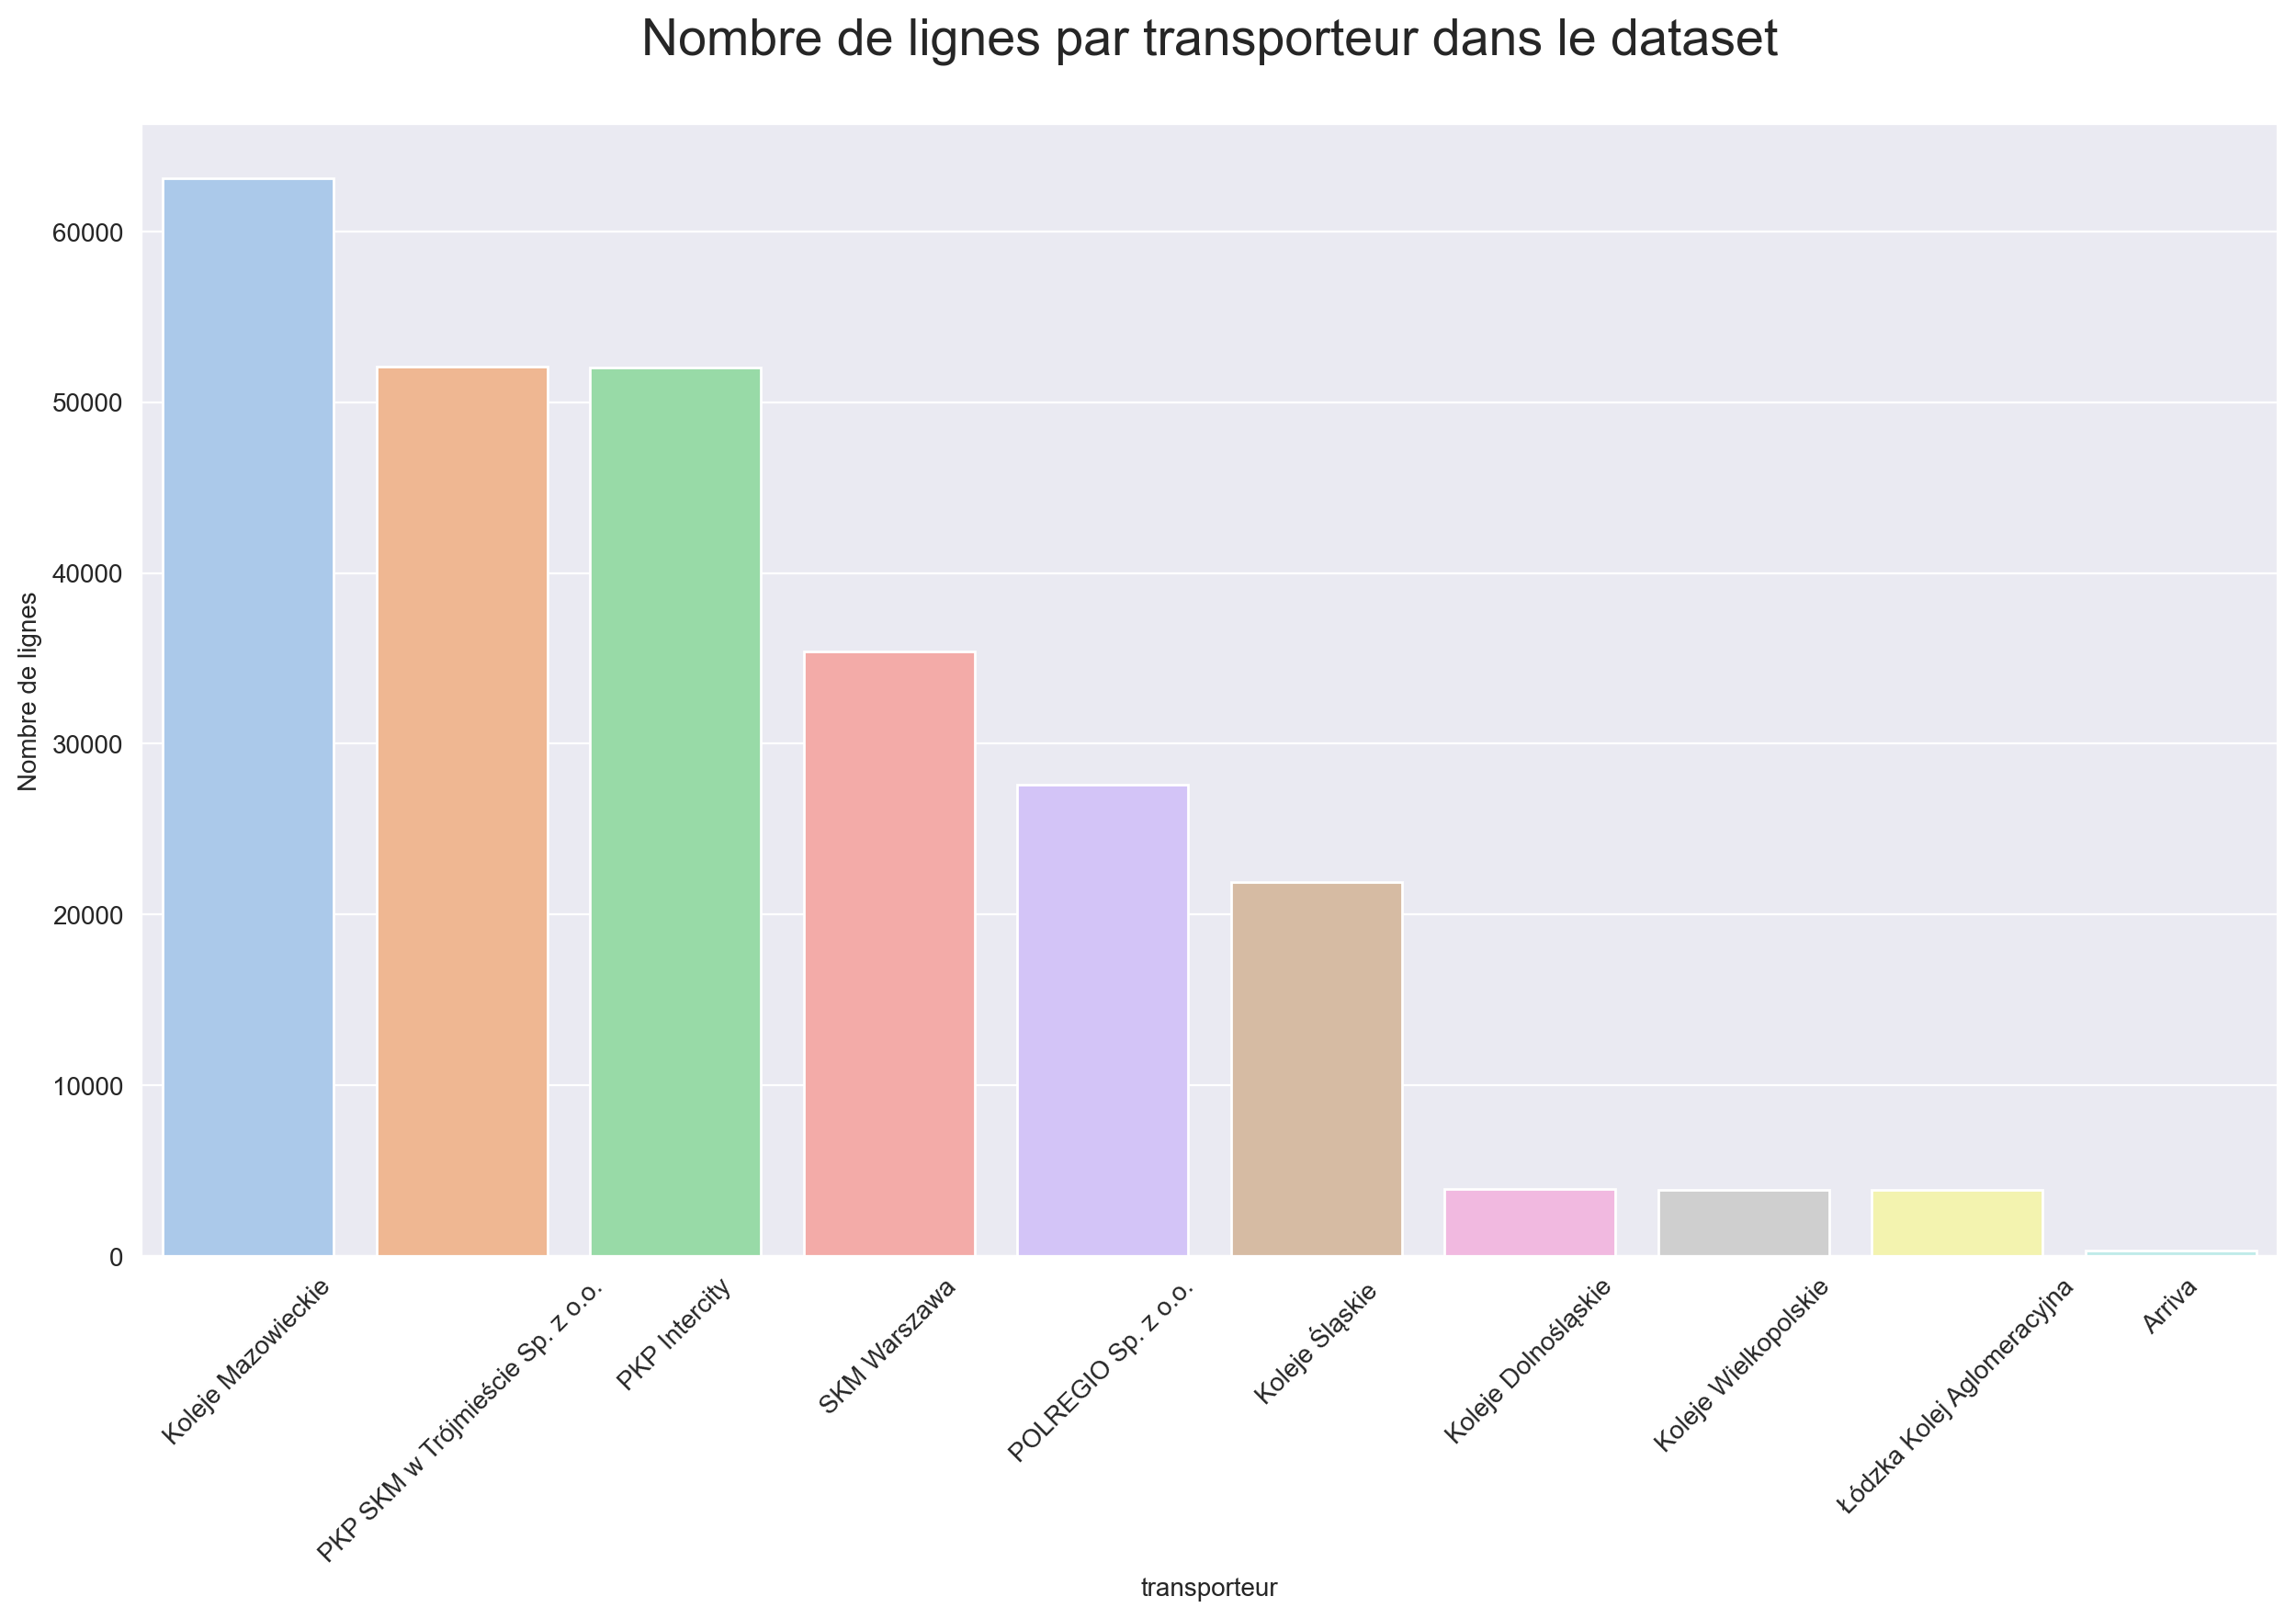

In [178]:
sns.barplot(data=df.groupby("transporteur").agg("count").sort_values("id_train_complet",ascending=False).rename(columns={"id_train_complet":"Nombre de lignes"}).reset_index(), 
            x="transporteur",
            y="Nombre de lignes")
plt.title("Nombre de lignes par transporteur dans le dataset\n",fontsize=20)
plt.xticks(rotation=45)
plt.show()

In [180]:
#Nombre moyen de lignes enregistrées toutes les 5 minutes 
df.groupby("datetime_save").agg("count").mean()

id_train_complet      65.641402
transporteur          65.641402
date_depart           65.641402
depart_destination    65.641402
arrivee_prevue        65.641402
retard                65.641402
nom_station           65.641402
id_train              65.641402
index_part1           65.641402
index_part2           65.641402
index_part3           65.641402
depart                65.641402
destination           65.641402
travel                65.641402
num_station           65.641402
dtype: float64

In [180]:
df[(df["id_train"]=='10102/3  ZAMENHOF')  & (df["datetime_save"]==datetime.strptime('2022-05-17 20:10:00','%Y-%m-%d %H:%M:%S'))]

,id_train,transporteur,trajet,depart,destination,date_depart,horaire_arrivee,datetime_save,last_station,retard_prevu,heure_arrivee,min_arrivee
517008,10102/3 ZAMENHOF,PKP Intercity,Warszawa Zachodnia - Białystok,Warszawa Zachodnia,Białystok,2022-05-17,20:18,2022-05-17 20:10:00,Warszawa Centralna,0,20,18
517180,10102/3 ZAMENHOF,PKP Intercity,Warszawa Zachodnia - Białystok,Warszawa Zachodnia,Białystok,2022-05-17,20:30,2022-05-17 20:10:00,Warszawa Wschodnia,0,20,30


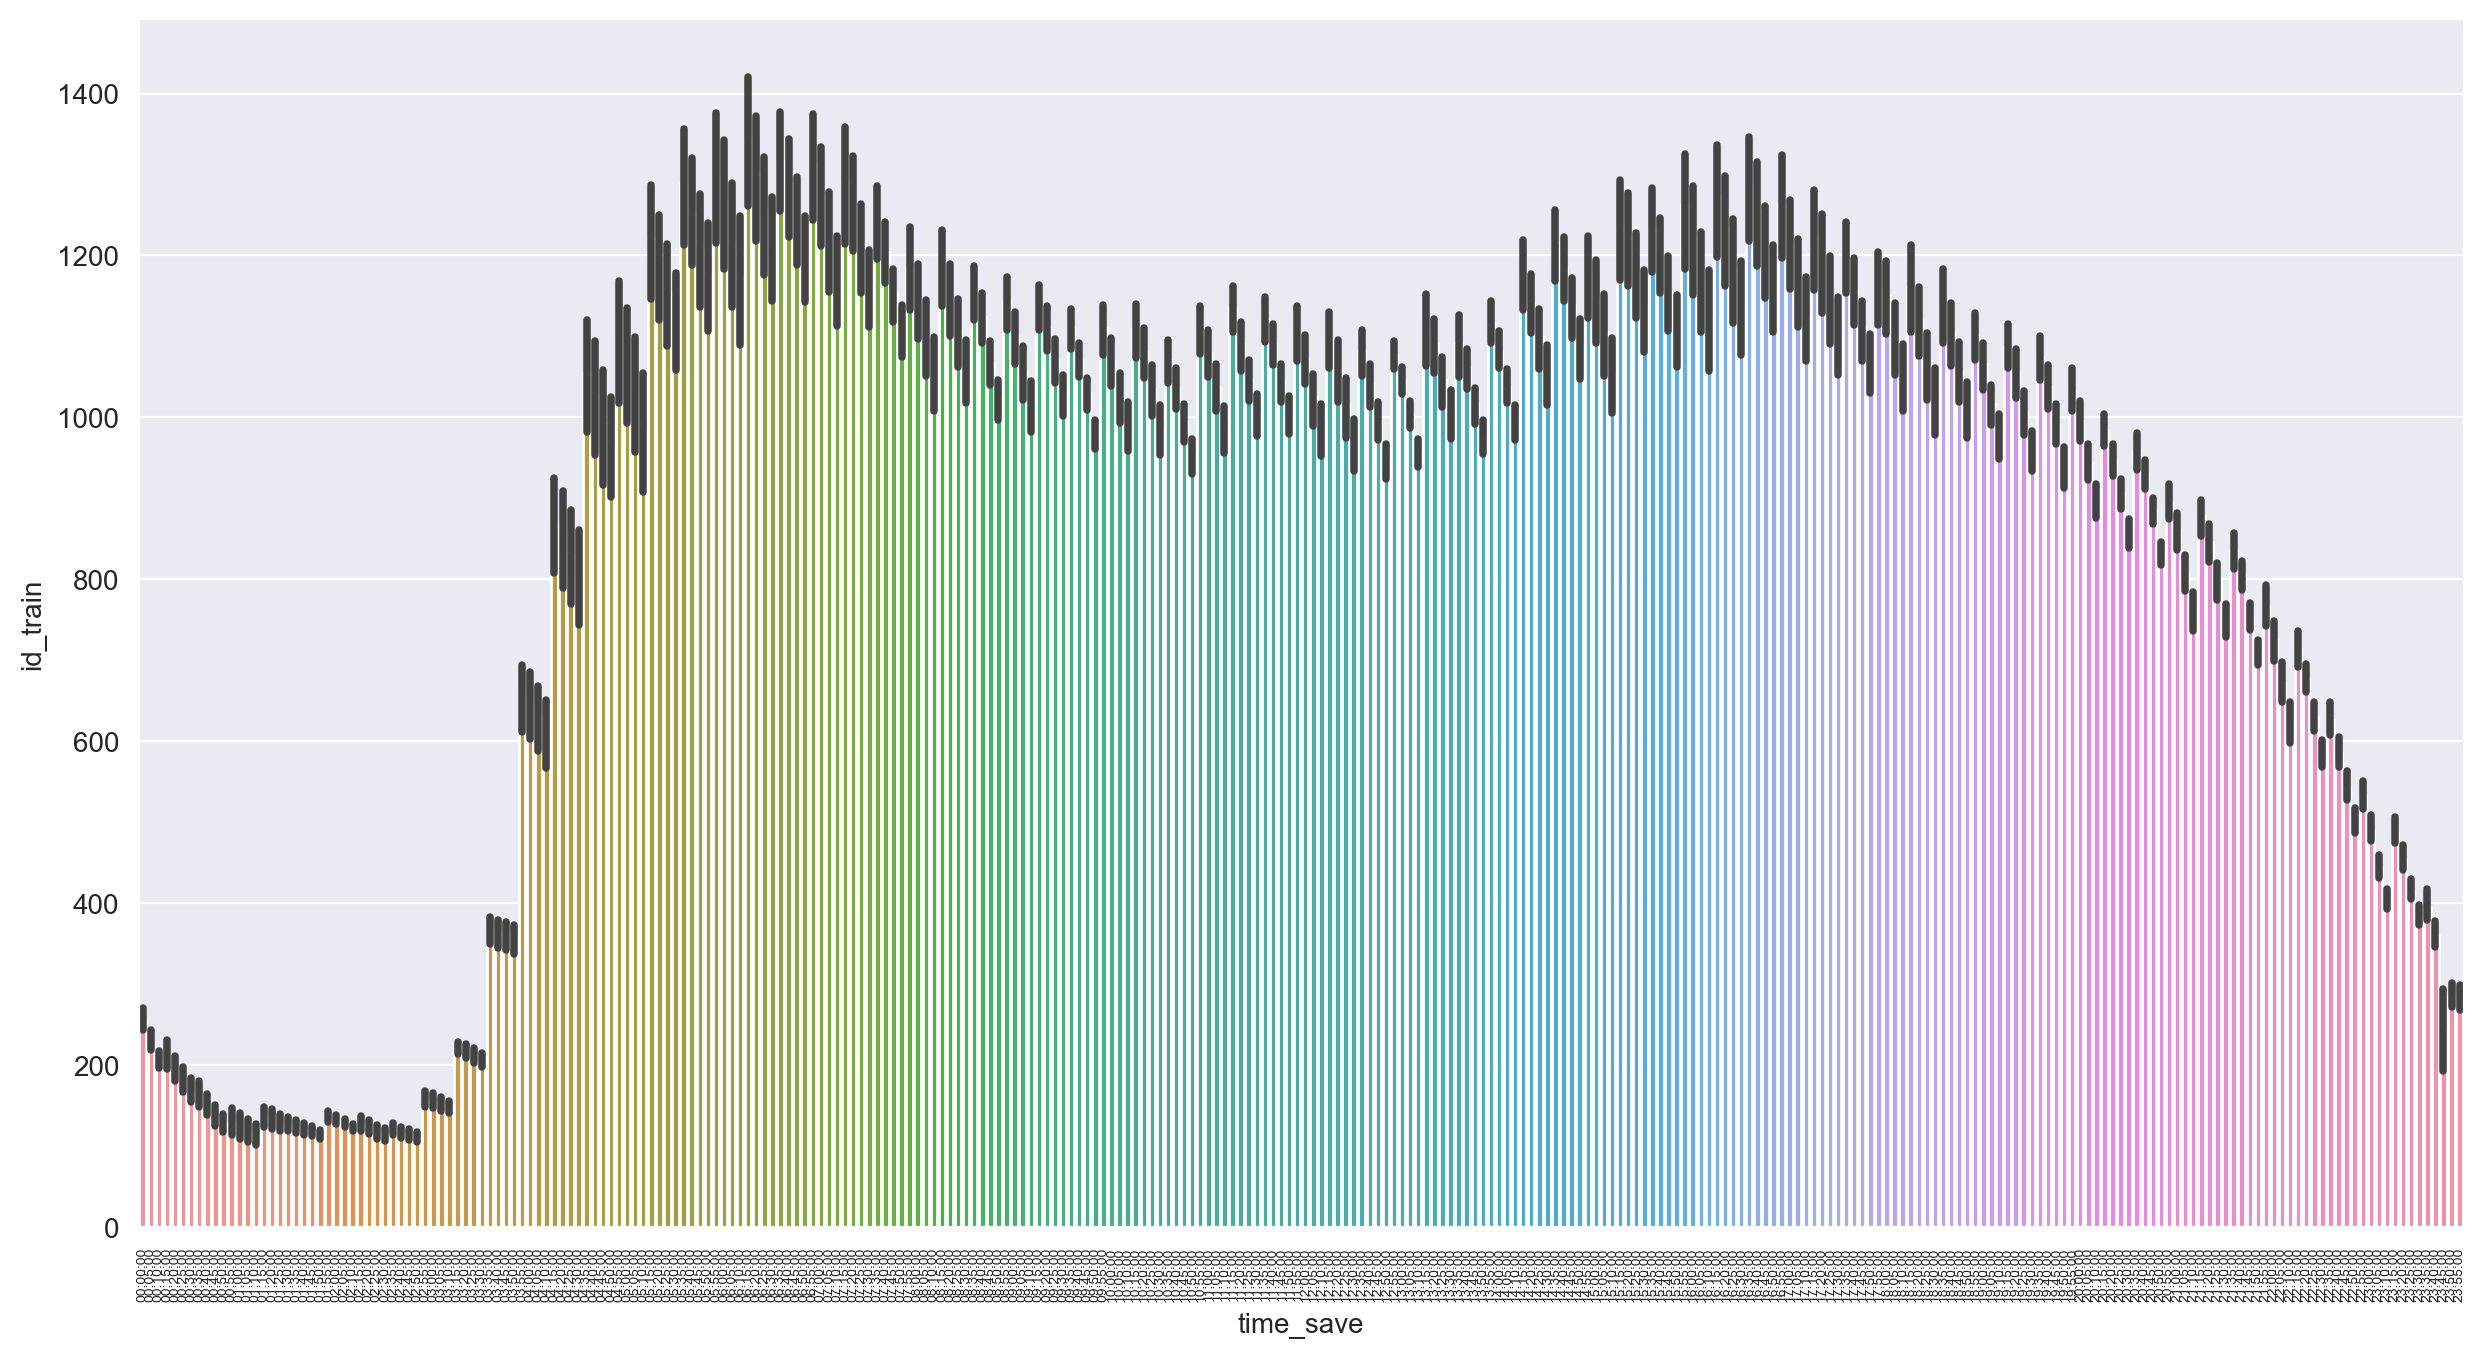

In [211]:
df_temp =df.copy(deep=True)
df_temp["date_save"]=df_temp["datetime_save"].dt.date
df_temp["time_save"]=df_temp["datetime_save"].dt.time

sns.barplot(data=df_temp.groupby(["date_save","time_save"]).agg("count").reset_index().sort_values("time_save"),
           x="time_save",y="id_train")
plt.xticks(rotation=90, fontsize=5)
plt.show()

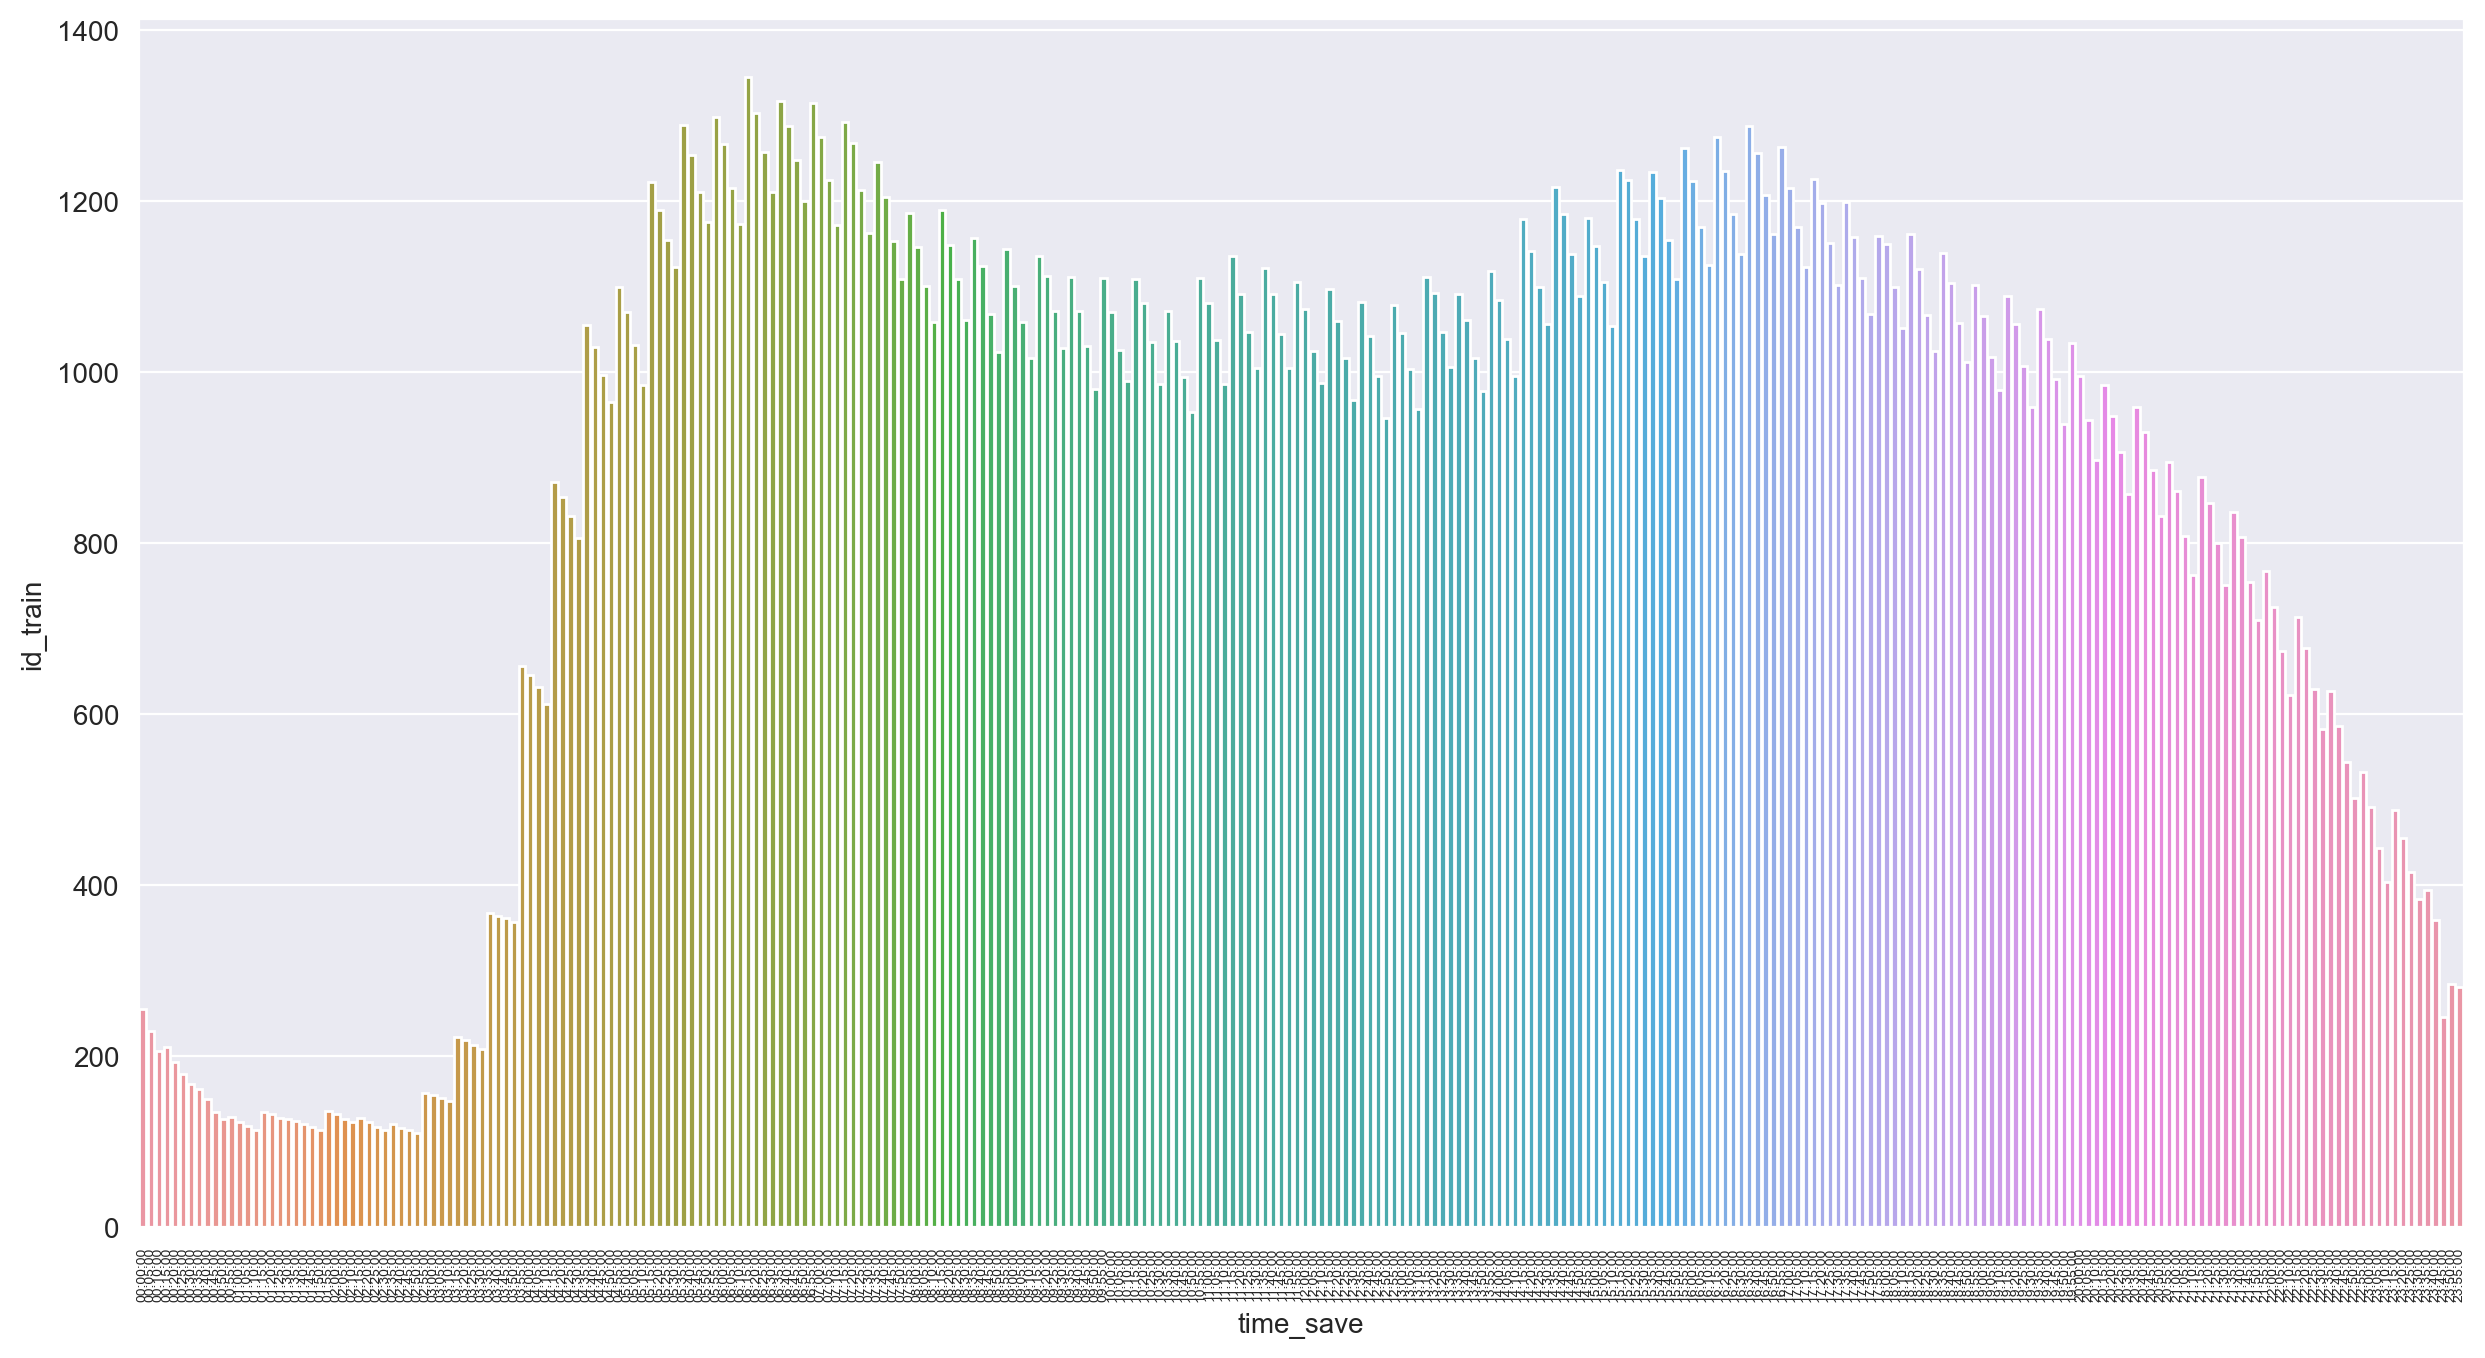

In [207]:
df_temp =df.copy(deep=True)
df_temp["date_save"]=df_temp["datetime_save"].dt.date
df_temp["time_save"]=df_temp["datetime_save"].dt.time

sns.barplot(data=df_temp.groupby(["date_save","time_save"]).agg("count").reset_index().groupby("time_save").agg("mean").reset_index().sort_values("time_save"),
           x="time_save",y="id_train")
plt.xticks(rotation=90, fontsize=5)
plt.show()

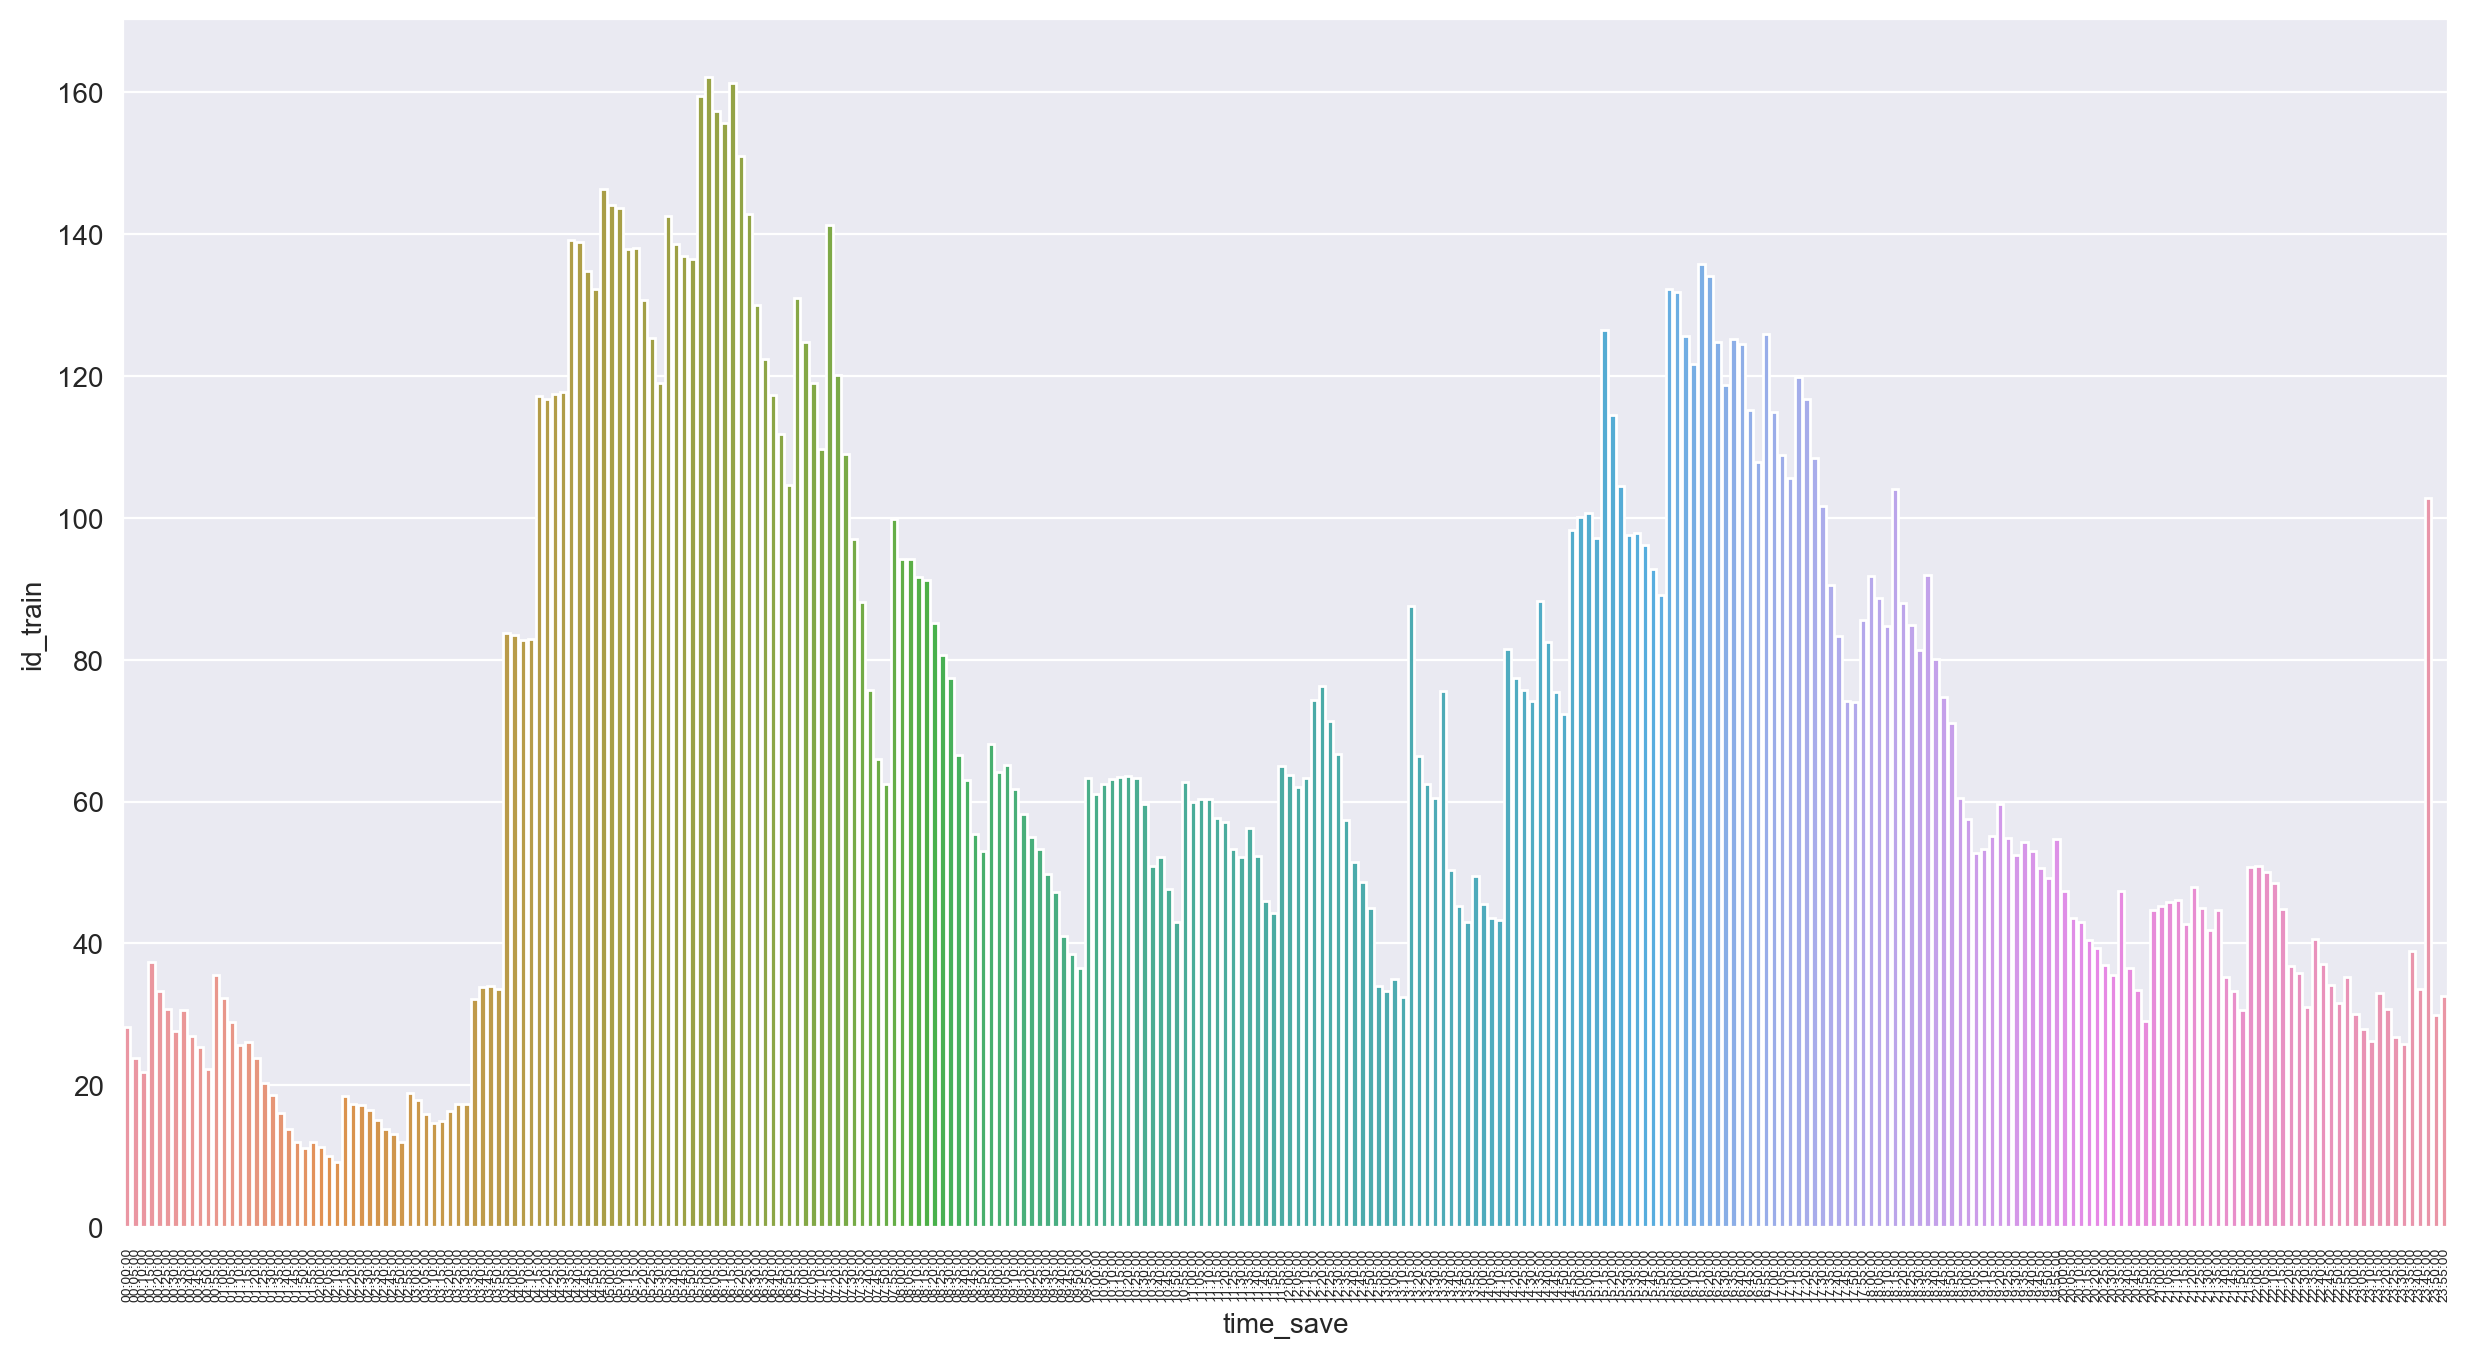

In [204]:
df_temp =df.copy(deep=True)
df_temp["date_save"]=df_temp["datetime_save"].dt.date
df_temp["time_save"]=df_temp["datetime_save"].dt.time

sns.barplot(data=df_temp.groupby(["date_save","time_save"]).agg("count").reset_index().groupby("time_save").agg("std").reset_index().sort_values("time_save"),
           x="time_save",y="id_train")


plt.xticks(rotation=90, fontsize=5)
plt.show()

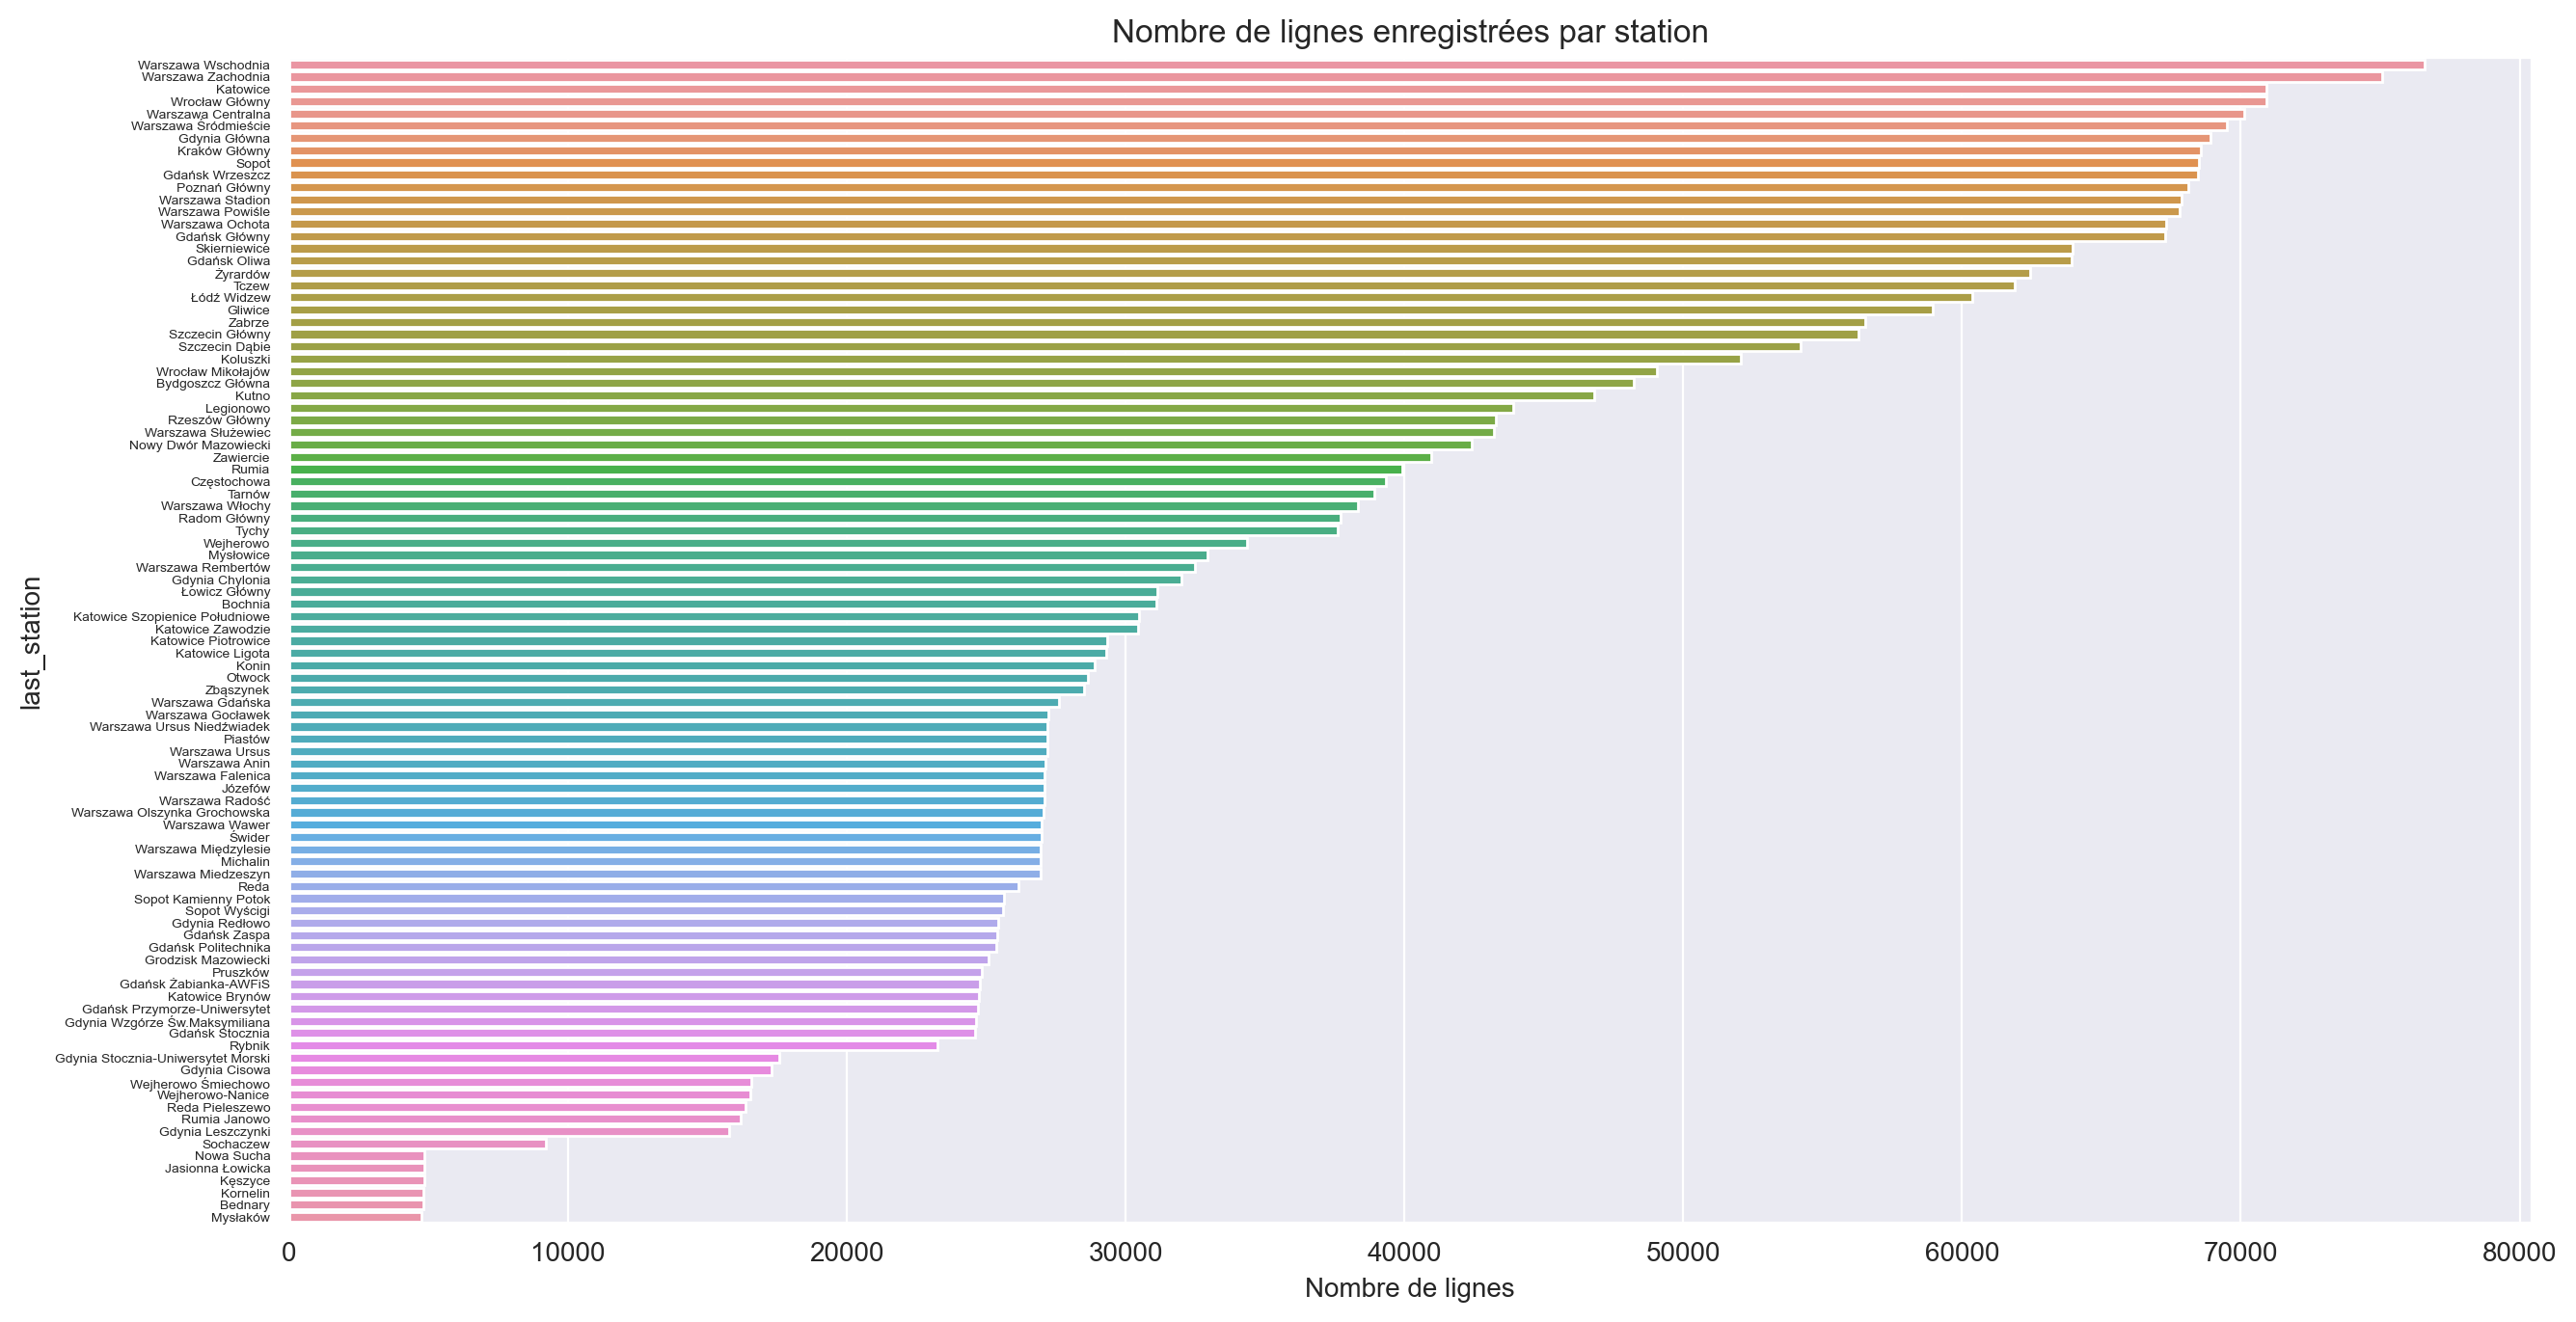

In [222]:
sns.barplot(data=df.groupby(["last_station"]).agg("count").reset_index().sort_values("retard_prevu",ascending=False),x="retard_prevu",y="last_station")

plt.yticks(fontsize=5)
plt.title("Nombre de lignes enregistrées par station")
plt.xlabel("Nombre de lignes")
plt.show()

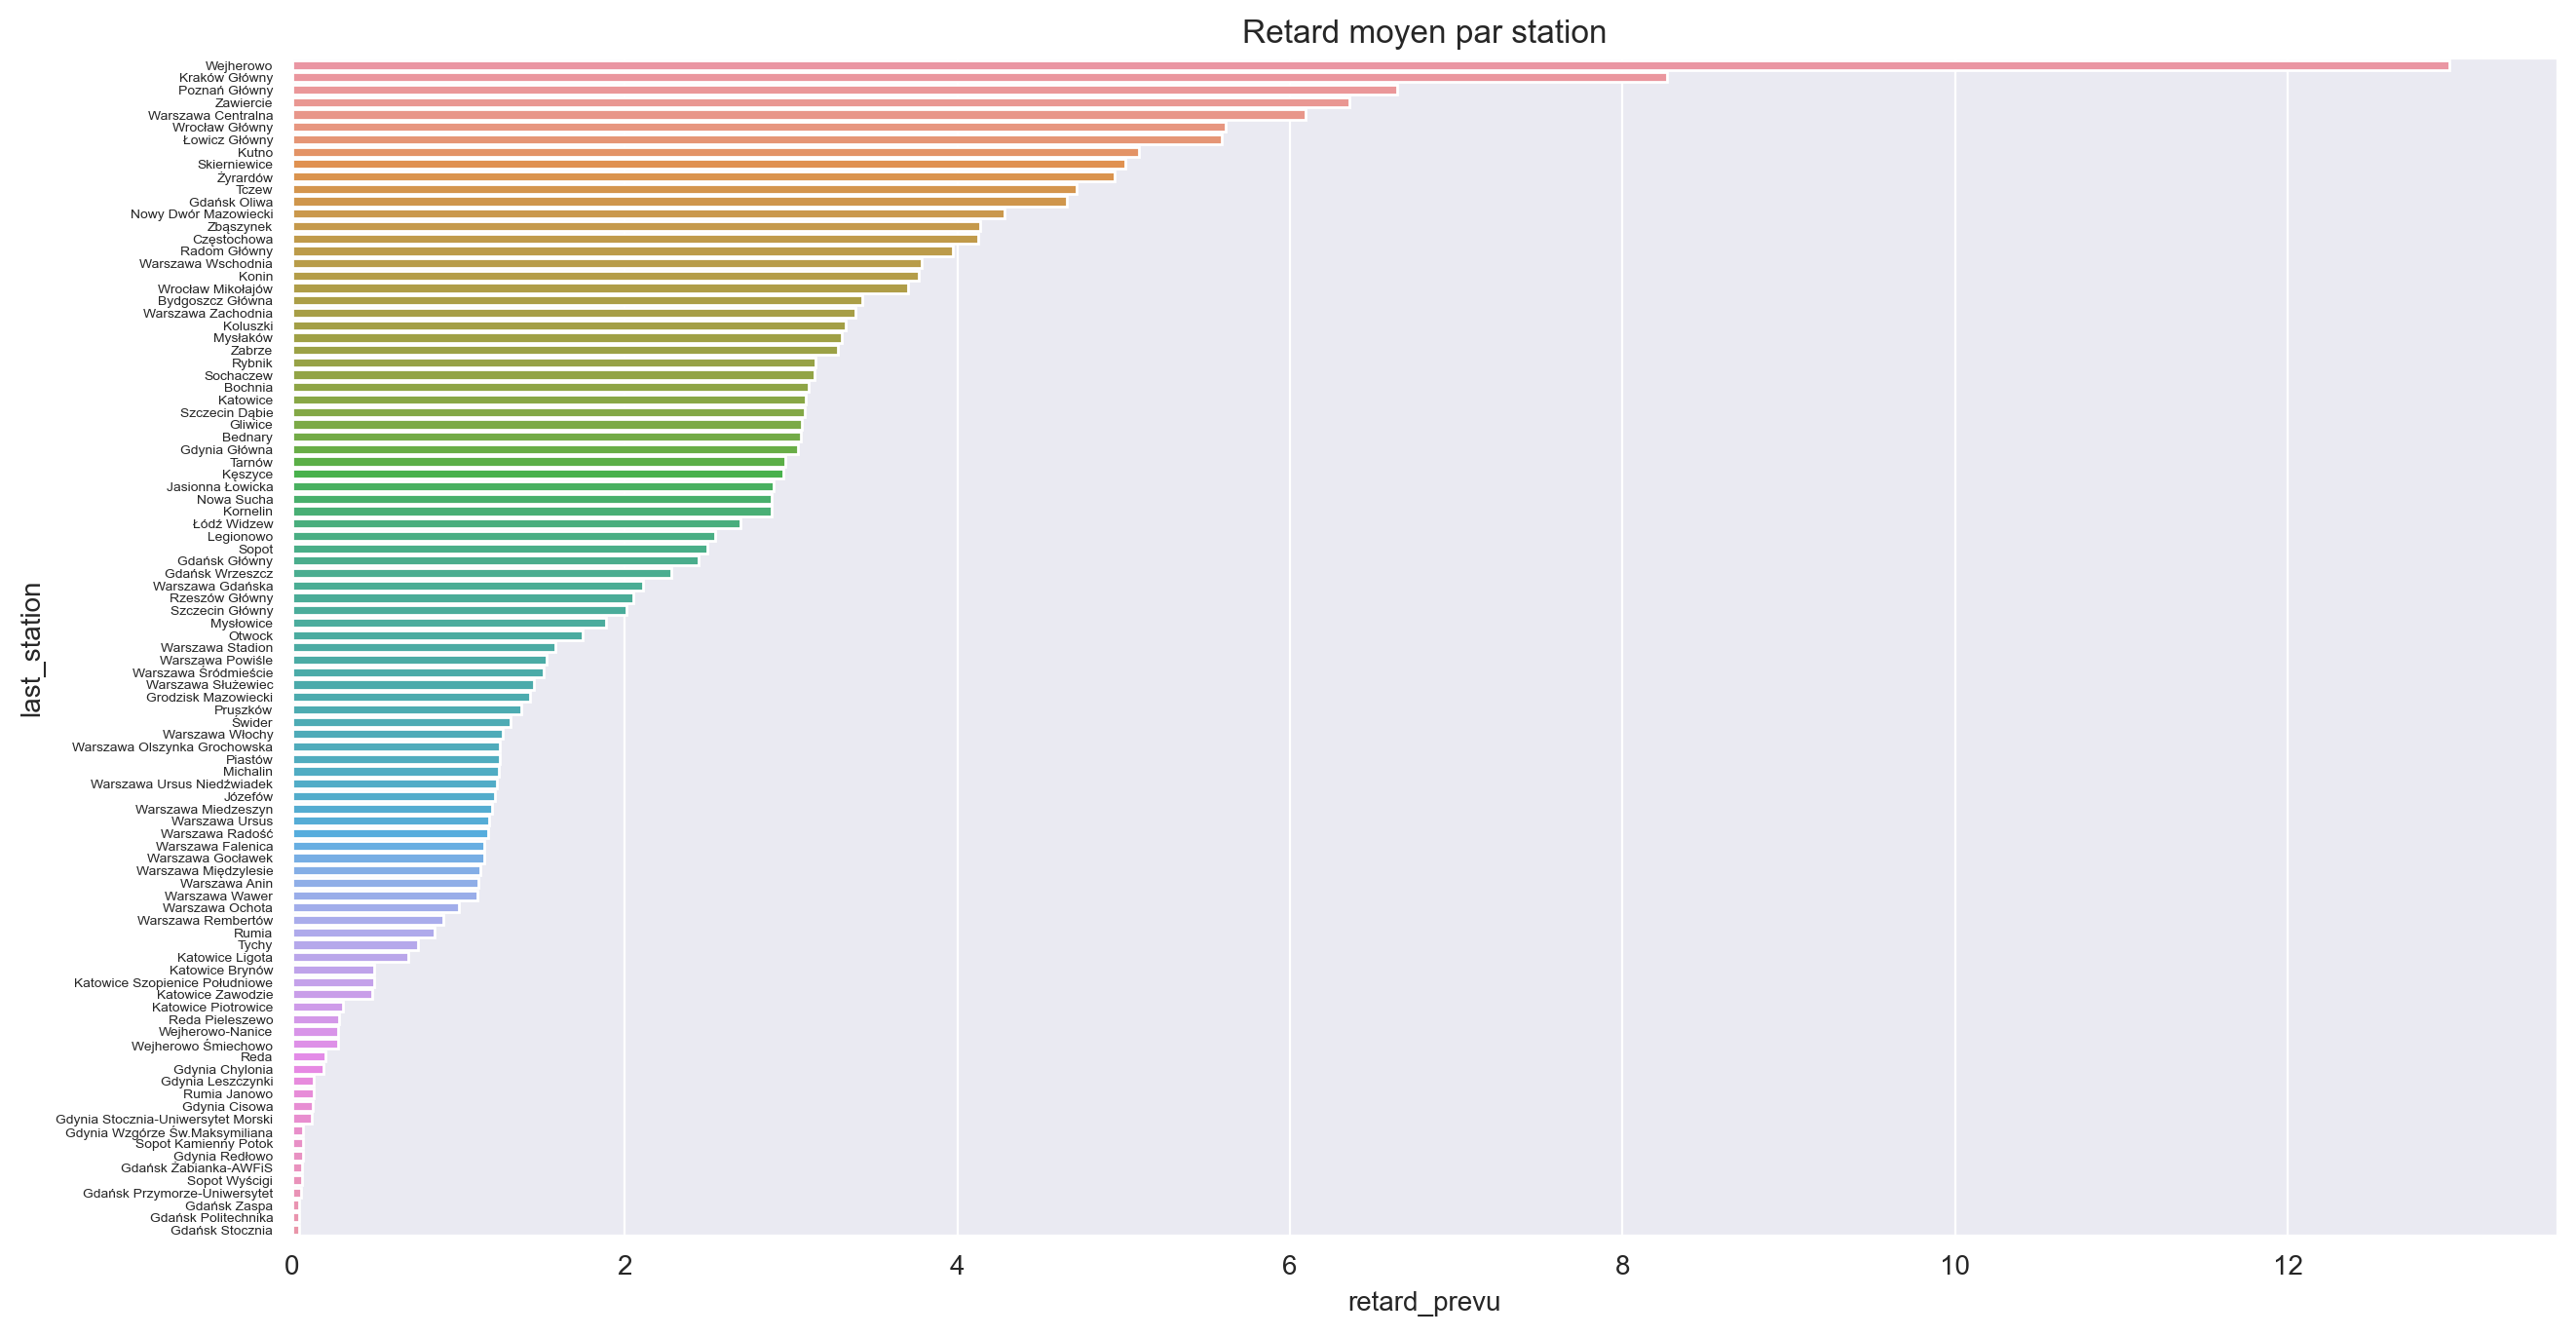

In [225]:
df_temp=df.groupby(["id_train","trajet","last_station"]).agg("mean").groupby("last_station").agg("mean").reset_index().sort_values("retard_prevu",ascending=False)
sns.barplot(data=df_temp,x="retard_prevu",y="last_station")

plt.yticks(fontsize=5)
plt.title("Retard moyen par station")
plt.show()